<a href="https://colab.research.google.com/github/net39/ML-anomaly-detection/blob/main/P2_06_CNN2_vid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

CNN-LSTM Human Action Recognition Pipeline

# Install Libraries and Google Access

In [3]:
from google.colab import auth
auth.authenticate_user()

from google.colab import drive
drive.mount('/content/drive')

from google.colab import files
files.upload()

from google.cloud import storage
import os
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/content/p2-anomaly-c4545180e308.json'

storage_client = storage.Client()
bucket_name = 'p2-anomaly'
bucket = storage_client.bucket(bucket_name)

Mounted at /content/drive


Saving p2-anomaly-c4545180e308.json to p2-anomaly-c4545180e308.json


In [4]:
# Install GCS and other dependencies
!pip install google-cloud-storage --quiet
!pip install opencv-python-headless --quiet
!pip install joblib --quiet
!pip install tensorflow --quiet
!pip install scikit-learn
!pip install tqdm
!pip install pandas

# Imports
import os
import cv2
import numpy as np
import pandas as pd
import json
import time
import shutil
from datetime import datetime
from tqdm import tqdm
import joblib

from collections import defaultdict
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM, TimeDistributed, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix



| Data Type   | Source Location                                   | Details                                  |
| :---------- | :------------------------------------------------ | :--------------------------------------- |
| Annotations | `p2-anomaly/processed/frame_labels.csv`           | CSV with `filename` and `action` columns |
| Frames      | `p2-anomaly/processed/preprocessed-mcfd/`         | Preprocessed images (resized, denoised)  |
| FPS         | \~30 FPS extraction interval (1 every 30 frames)  | Uniform sampling done already            |
| Actions     | 35 unique actions (plus added `empty_room` label) | Single-label multi-class classification  |


In [5]:
# Hyperparameters
IMG_SIZE = (224, 224)
IMG_CHANNELS = 3
SEQUENCE_LENGTH = 5
BATCH_SIZE = 16
EPOCHS = 20

In [6]:
if not os.path.exists('/content/frame_labels.csv'):
    blob = bucket.blob('processed/frame_labels.csv')
    blob.download_to_filename('/content/frame_labels.csv')
    print("Downloaded frame_labels.csv from GCS.")
else:
    print("frame_labels.csv already exists locally.")

# Load Labels CSV
label_df = pd.read_csv('/content/frame_labels.csv')
unique_actions = label_df['action'].unique()

# Encode Labels
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(label_df['action'])
onehot_encoder = OneHotEncoder(sparse_output=False)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded.reshape(-1, 1))


Downloaded frame_labels.csv from GCS.


In [7]:
image_dir = '/content/preprocessed-mcfd/'

# Check and download images if folder doesn't exist
if not os.path.exists(image_dir):
    os.makedirs(image_dir, exist_ok=True)
    blobs = bucket.list_blobs(prefix='processed/preprocessed-mcfd/')
    for blob in blobs:
        if blob.name.endswith(('.jpg', '.png')):
            local_path = os.path.join('/content', blob.name.split('processed/')[1])
            os.makedirs(os.path.dirname(local_path), exist_ok=True)
            blob.download_to_filename(local_path)
    print("Downloaded all preprocessed frames from GCS.")
else:
    print("Preprocessed-mcfd folder already exists locally.")


Downloaded all preprocessed frames from GCS.


In [8]:
# Load Images and Labels
image_dir = '/content/preprocessed-mcfd/'  # local path after downloading from GCS
X = []
Y = []

missing_count = 0
for idx, row in tqdm(label_df.iterrows(), total=label_df.shape[0]):
    img_path = os.path.join('/content', row['filename'].replace('processed/', ''))
    if os.path.exists(img_path):
        img = cv2.imread(img_path)
        img = cv2.resize(img, IMG_SIZE)
        X.append(img)
        Y.append(onehot_encoded[idx])
    else:
        missing_count += 1

print(f"Total missing images: {missing_count}")

X = np.array(X)
Y = np.array(Y)


100%|██████████| 1000/1000 [00:00<00:00, 1175.63it/s]

Total missing images: 0


In [9]:
print(f"Total images loaded: {len(X)}")
print(f"Total labels loaded: {len(Y)}")
print(f"Unique actions: {unique_actions}")

Total images loaded: 1000
Total labels loaded: 1000
Unique actions: ['walking' 'empty_room' 'bending' 'lying_down' 'fallen' 'sitting'
 'standing' 'crouch_down' 'kneeling' 'unidentified' 'carry_item'
 'housekeeping' 'gathering' 'occlusion' 'sleeping' 'using_laptop'
 'crawling']


In [10]:
import glob

image_files = glob.glob('/content/preprocessed-mcfd/**/*.jpg', recursive=True)
print(f"Total images in local preprocessed-mcfd/: {len(image_files)}")

Total images in local preprocessed-mcfd/: 8795


In [11]:
label_counts = np.sum(Y, axis=0)
for label, count in zip(label_encoder.classes_, label_counts):
    print(f"{label}: {count}")

bending: 30.0
carry_item: 15.0
crawling: 1.0
crouch_down: 38.0
empty_room: 245.0
fallen: 202.0
gathering: 15.0
housekeeping: 36.0
kneeling: 13.0
lying_down: 17.0
occlusion: 10.0
sitting: 70.0
sleeping: 4.0
standing: 132.0
unidentified: 14.0
using_laptop: 1.0
walking: 157.0


In [12]:
min_count = 2
valid_class_indices = [i for i, c in enumerate(label_counts) if c >= min_count]
print("Valid classes:", [label_encoder.classes_[i] for i in valid_class_indices])


Valid classes: ['bending', 'carry_item', 'crouch_down', 'empty_room', 'fallen', 'gathering', 'housekeeping', 'kneeling', 'lying_down', 'occlusion', 'sitting', 'sleeping', 'standing', 'unidentified', 'walking']


In [13]:
X_filtered = []
Y_filtered = []

for i in range(len(Y)):
    if any(Y[i][j] == 1 and j in valid_class_indices for j in range(len(Y[i]))):
        filtered_label = Y[i][valid_class_indices]
        X_filtered.append(X[i])
        Y_filtered.append(filtered_label)

X = np.array(X_filtered)
Y = np.array(Y_filtered)

In [14]:
min_count = 2
mask = np.sum(Y, axis=1).astype(bool)
counts = np.sum(Y, axis=0)
valid_classes = [i for i, c in enumerate(counts) if c >= min_count]

label_counts_filtered = np.sum(Y, axis=0)
for label, count in zip(valid_classes, label_counts_filtered):
    print(f"{label}: {count:.1f}")

print(f"\n New total images: {len(X)}")
print(f" New total labels: {len(Y)}")

0: 30.0
1: 15.0
2: 38.0
3: 245.0
4: 202.0
5: 15.0
6: 36.0
7: 13.0
8: 17.0
9: 10.0
10: 70.0
11: 4.0
12: 132.0
13: 14.0
14: 157.0

 New total images: 998
 New total labels: 998


In GCS CLI - gsutil ls gs://p2-anomaly/processed/preprocessed-mcfd/** | wc -l
there are **8795 images in total across all chutes and cams**.

Only 1000 of them are annotated in frame_labels.csv and the rest are unlabelled



In [15]:
# Train-Validation-Test Split

# First split
X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.3, random_state=42, stratify=Y)

# Check class counts in Y_temp
temp_label_counts = np.sum(Y_temp, axis=0)
print("Class counts in Y_temp before second split:")
for i, count in enumerate(temp_label_counts):
    print(f"Class {i}: {count}")


# Filter out classes with only one sample in Y_temp for the second split
valid_temp_classes_indices = [i for i, count in enumerate(temp_label_counts) if count >= 2]

X_temp_filtered = []
Y_temp_filtered = []

# This filtering assumes Y_temp is already one-hot encoded
for i in range(len(Y_temp)):
    # Check if the sample belongs to any of the valid temp classes
    if any(Y_temp[i][j] == 1 for j in valid_temp_classes_indices):
        # Create a new one-hot encoded vector with only the valid classes
        # We need to map the original class indices to the new filtered indices
        original_class_index = np.argmax(Y_temp[i])
        if original_class_index in valid_temp_classes_indices:
            X_temp_filtered.append(X_temp[i])
            # Create a new one-hot vector for the filtered classes
            filtered_onehot = np.zeros(len(valid_temp_classes_indices))
            new_index = valid_temp_classes_indices.index(original_class_index)
            filtered_onehot[new_index] = 1
            Y_temp_filtered.append(filtered_onehot)

X_temp_filtered = np.array(X_temp_filtered)
Y_temp_filtered = np.array(Y_temp_filtered)


# Second split with filtered data
X_val, X_test, Y_val, Y_test = train_test_split(X_temp_filtered, Y_temp_filtered, test_size=0.5, random_state=42, stratify=Y_temp_filtered)


print(f"\n Train set: {len(X_train)}, Val set: {len(X_val)}, Test set: {len(X_test)}")

Class counts in Y_temp before second split:
Class 0: 9.0
Class 1: 4.0
Class 2: 11.0
Class 3: 74.0
Class 4: 61.0
Class 5: 5.0
Class 6: 11.0
Class 7: 4.0
Class 8: 5.0
Class 9: 3.0
Class 10: 21.0
Class 11: 1.0
Class 12: 40.0
Class 13: 4.0
Class 14: 47.0

 Train set: 698, Val set: 149, Test set: 150


In [26]:
new_classes = [label_encoder.classes_[i] for i in valid_class_indices]
print("Filtered Classes:", new_classes)

Filtered Classes: ['bending', 'carry_item', 'crouch_down', 'empty_room', 'fallen', 'gathering', 'housekeeping', 'kneeling', 'lying_down', 'occlusion', 'sitting', 'sleeping', 'standing', 'unidentified', 'walking']


In [27]:
print("Train classes:", Y_train.shape[1])
print("Val classes:", Y_val.shape[1])

Train classes: 15
Val classes: 15


In [28]:
def pad_labels(Y, target_size):
    padded_Y = np.zeros((Y.shape[0], target_size))
    padded_Y[:, :Y.shape[1]] = Y
    return padded_Y

Y_val = pad_labels(Y_val, Y_train.shape[1])
Y_test = pad_labels(Y_test, Y_train.shape[1])

In [29]:
# Prepare Sequences for LSTM - group consecutive frames into sequences
def create_sequences(X, Y, seq_length):
    X_seq, Y_seq = [], []
    for i in range(len(X) - seq_length):
        X_seq.append(X[i:i+seq_length])
        Y_seq.append(Y[i+seq_length-1])
    return np.array(X_seq), np.array(Y_seq)

X_train_seq, Y_train_seq = create_sequences(X_train, Y_train, SEQUENCE_LENGTH)
X_val_seq, Y_val_seq = create_sequences(X_val, Y_val, SEQUENCE_LENGTH)



In [30]:
# Build CNN-LSTM Model
base_cnn = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_cnn.layers:
    layer.trainable = False

cnn_model = Sequential([
    base_cnn,
    GlobalAveragePooling2D()
])

# Get the number of valid classes after filtering
num_valid_classes = Y_train_seq.shape[-1]

model = Sequential([
    TimeDistributed(cnn_model, input_shape=(SEQUENCE_LENGTH, 224, 224, 3)),
    LSTM(128, return_sequences=False),
    Dropout(0.5),
    Dense(len(valid_class_indices), activation='softmax')
    #Dense(Y_train_seq.shape[-1], activation='softmax'
])

model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_2              │ (None, 5, 512)         │    20,024,384 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 128)            │       328,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 15)             │         1,935 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,354,511 (77.65 MB)

 Trainable params: 330,127 (1.26 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [31]:
def evaluate_model(model, X_test_seq, Y_test_seq, new_classes):
    Y_pred = model.predict(X_test_seq)
    Y_pred_labels = np.argmax(Y_pred, axis=1)
    Y_true_labels = np.argmax(Y_test_seq, axis=1)

    print("\n Classification Report:")
    print(classification_report(Y_true_labels, Y_pred_labels, target_names=new_classes, zero_division=0))

    cm = confusion_matrix(Y_true_labels, Y_pred_labels)
    cm_df = pd.DataFrame(cm, index=new_classes, columns=new_classes)
    print("\n Confusion Matrix:")
    print(cm_df)

In [32]:
train_counts = np.sum(Y_train_seq, axis=0)
for i, c in enumerate(train_counts):
    print(f"{new_classes[i]}: {c}")

bending: 21.0
carry_item: 11.0
crouch_down: 27.0
empty_room: 169.0
fallen: 140.0
gathering: 10.0
housekeeping: 25.0
kneeling: 9.0
lying_down: 12.0
occlusion: 7.0
sitting: 49.0
sleeping: 3.0
standing: 90.0
unidentified: 10.0
walking: 110.0


In [33]:
Y_train_labels = np.argmax(Y_train_seq, axis=1)

from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(Y_train_labels),
    y=Y_train_labels
)

print(dict(enumerate(new_classes)))
print(class_weights)

{0: 'bending', 1: 'carry_item', 2: 'crouch_down', 3: 'empty_room', 4: 'fallen', 5: 'gathering', 6: 'housekeeping', 7: 'kneeling', 8: 'lying_down', 9: 'occlusion', 10: 'sitting', 11: 'sleeping', 12: 'standing', 13: 'unidentified', 14: 'walking'}
[ 2.2         4.2         1.71111111  0.27337278  0.33        4.62
  1.848       5.13333333  3.85        6.6         0.94285714 15.4
  0.51333333  4.62        0.42      ]


In [34]:
Y_train_labels = np.argmax(Y_train_seq, axis=1)
Y_val_labels = np.argmax(Y_val_seq, axis=1)

In [35]:
model.compile(optimizer=Adam(1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_2              │ (None, 5, 512)         │    20,024,384 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 128)            │       328,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 15)             │         1,935 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,354,511 (77.65 MB)

 Trainable params: 330,127 (1.26 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [36]:
# Train Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint('/content/best_model.h5', save_best_only=True)
]

class_weights_dict = dict(enumerate(class_weights))

model.fit(
    X_train_seq, Y_train_labels,
    validation_data=(X_val_seq, Y_val_labels),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=callbacks,
    class_weight=class_weights_dict
)

Epoch 1/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.1090 - loss: 2.6839

44/44 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - accuracy: 0.1084 - loss: 2.6902 - val_accuracy: 0.0972 - val_loss: 2.7190
Epoch 2/20
43/44 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.0873 - loss: 2.6959

44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - accuracy: 0.0882 - loss: 2.6969 - val_accuracy: 0.1181 - val_loss: 2.6704
Epoch 3/20
43/44 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.1241 - loss: 2.7777

44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step - accuracy: 0.1245 - loss: 2.7730 - val_accuracy: 0.1250 - val_loss: 2.6437
Epoch 4/20
43/44 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.1611 - loss: 2.6439

44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - accuracy: 0.1612 - loss: 2.6398 - val_accuracy: 0.1667 - val_loss: 2.6322
Epoch 5/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - accuracy: 0.1682 - loss: 2.6516 - val_accuracy: 0.1806 - val_loss: 2.6532
Epoch 6/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - accuracy: 0.1790 - loss: 2.2368 - val_accuracy: 0.1597 - val_loss: 2.6431
Epoch 7/20
43/44 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.1792 - loss: 2.5869

44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - accuracy: 0.1795 - loss: 2.5734 - val_accuracy: 0.2014 - val_loss: 2.6234
Epoch 8/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - accuracy: 0.1960 - loss: 2.1991 - val_accuracy: 0.1389 - val_loss: 2.6969
Epoch 9/20
43/44 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.1881 - loss: 2.0684

44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - accuracy: 0.1890 - loss: 2.0715 - val_accuracy: 0.1806 - val_loss: 2.6116
Epoch 10/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - accuracy: 0.2342 - loss: 2.1966 - val_accuracy: 0.1875 - val_loss: 2.6570
Epoch 11/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - accuracy: 0.2619 - loss: 1.9857 - val_accuracy: 0.1806 - val_loss: 2.6427
Epoch 12/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - accuracy: 0.2501 - loss: 1.9114 - val_accuracy: 0.1806 - val_loss: 2.6568
Epoch 13/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - accuracy: 0.2634 - loss: 1.8743 - val_accuracy: 0.1528 - val_loss: 2.6136
Epoch 14/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - accuracy: 0.2827 - loss: 1.9018 - val_accuracy: 0.2083 - val_loss: 2.6445


In [37]:
# Evaluate on Test Set
X_test_seq, Y_test_seq = create_sequences(X_test, Y_test, SEQUENCE_LENGTH)
Y_pred = model.predict(X_test_seq)
Y_pred_labels = np.argmax(Y_pred, axis=1)
Y_true_labels = np.argmax(Y_test_seq, axis=1)


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 435ms/step


In [38]:
new_classes = [label_encoder.classes_[i] for i in valid_class_indices]
print(classification_report(Y_true_labels, Y_pred_labels, target_names=new_classes))

              precision    recall  f1-score   support

     bending       0.00      0.00      0.00         4
  carry_item       0.00      0.00      0.00         1
 crouch_down       0.00      0.00      0.00         6
  empty_room       0.35      0.50      0.41        36
      fallen       0.50      0.07      0.12        29
   gathering       0.14      0.50      0.22         2
housekeeping       0.00      0.00      0.00         6
    kneeling       0.00      0.00      0.00         2
  lying_down       0.00      0.00      0.00         2
   occlusion       0.00      0.00      0.00         1
     sitting       0.57      0.36      0.44        11
    sleeping       0.00      0.00      0.00        19
    standing       0.00      0.00      0.00         2
unidentified       0.00      0.00      0.00        24
     walking       0.00      0.00      0.00         0

    accuracy                           0.17       145
   macro avg       0.10      0.10      0.08       145
weighted avg       0.23   

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

In [39]:
cm = confusion_matrix(Y_true_labels, Y_pred_labels)
cm_df = pd.DataFrame(cm, index=new_classes, columns=new_classes)
print(cm_df)

              bending  carry_item  crouch_down  empty_room  fallen  gathering  \
bending             0           1            0           0       0          0   
carry_item          0           0            0           1       0          0   
crouch_down         0           0            0           1       0          1   
empty_room          0           1            3          18       1          1   
fallen              0           1            2          10       2          1   
gathering           0           0            0           1       0          1   
housekeeping        0           0            1           2       0          0   
kneeling            0           0            0           0       0          1   
lying_down          0           0            0           1       0          0   
occlusion           0           0            0           0       0          0   
sitting             0           0            0           2       0          1   
sleeping            0       

In [40]:
# Save Model & Label Encoder
model.save('/content/cnn_lstm_action_classifier.h5')
joblib.dump(label_encoder, '/content/label_encoder.joblib')


['/content/label_encoder.joblib']

In [41]:
# Upload back to GCS
bucket.blob('models/cnn_lstm_action_classifier.h5').upload_from_filename('/content/cnn_lstm_action_classifier.h5')
bucket.blob('models/label_encoder.joblib').upload_from_filename('/content/label_encoder.joblib')

# Apply detection logic: extract frames → preprocess → form sequences → predict → log to CSV / stream to Power BI/Tableau


# Attempt 2

In [42]:
# Labels to remove
remove_labels = ['empty_room', 'occlusion', 'unidentified']

remove_indices = [i for i, label in enumerate(label_encoder.classes_) if label in remove_labels]
print("Removing class indices:", remove_indices)

keep_indices = [i for i in range(len(label_encoder.classes_)) if i not in remove_indices]


X_clean = []
Y_clean = []

for i in range(len(Y)):
    label_index = np.argmax(Y[i])
    if label_index in keep_indices:
        X_clean.append(X[i])
        # One-hot encode to new index range
        new_label_index = keep_indices.index(label_index)
        new_Y = np.zeros(len(keep_indices))
        new_Y[new_label_index] = 1
        Y_clean.append(new_Y)

X_clean = np.array(X_clean)
Y_clean = np.array(Y_clean)

print("Cleaned dataset shape:", X_clean.shape, Y_clean.shape)

Removing class indices: [4, 10, 14]
Cleaned dataset shape: (569, 224, 224, 3) (569, 14)


In [43]:
# New class names
new_class_names = [label_encoder.classes_[i] for i in keep_indices]
print("Remaining classes:", new_class_names)

Remaining classes: ['bending', 'carry_item', 'crawling', 'crouch_down', 'fallen', 'gathering', 'housekeeping', 'kneeling', 'lying_down', 'sitting', 'sleeping', 'standing', 'using_laptop', 'walking']


In [44]:
# Get label indices from one-hot
Y_clean_labels = np.argmax(Y_clean, axis=1)

# Count per class
unique, counts = np.unique(Y_clean_labels, return_counts=True)

for i, c in zip(unique, counts):
    print(f"{new_class_names[i]}: {c}")

bending: 30
carry_item: 15
crawling: 38
crouch_down: 245
fallen: 15
gathering: 36
housekeeping: 13
kneeling: 17
lying_down: 10
sitting: 4
sleeping: 132
standing: 14


In [49]:
print("Unique labels in Y_true_labels:", np.unique(Y_true_labels))
print("Unique labels in Y_pred_labels:", np.unique(Y_pred_labels))
print("Length of new_class_names:", len(new_class_names))

Unique labels in Y_true_labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
Unique labels in Y_pred_labels: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]
Length of new_class_names: 14


In [50]:
# Train-validation-test split
X_train, X_temp, Y_train, Y_temp = train_test_split(X_aug, Y_aug, test_size=0.3, random_state=42, stratify=Y_aug)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42, stratify=Y_temp)

# Create sequences for LSTM
def create_sequences(X, Y, seq_length):
    X_seq, Y_seq = [], []
    for i in range(len(X) - seq_length):
        X_seq.append(X[i:i+seq_length])
        Y_seq.append(Y[i+seq_length-1])
    return np.array(X_seq), np.array(Y_seq)

X_train_seq, Y_train_seq = create_sequences(X_train, Y_train, SEQUENCE_LENGTH)
X_val_seq, Y_val_seq = create_sequences(X_val, Y_val, SEQUENCE_LENGTH)
X_test_seq, Y_test_seq = create_sequences(X_test, Y_test, SEQUENCE_LENGTH)

In [46]:
!pip install albumentations


In [47]:
import albumentations as A
import cv2

# Define augmentation pipeline
augment = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Rotate(limit=20, p=0.3),
    A.GaussNoise(p=0.2),
    A.MotionBlur(p=0.2)
])

def augment_image(image):
    # Albumentations expects images in uint8, HWC format
    image = image.astype('uint8')
    augmented = augment(image=image)
    return augmented['image']

In [48]:
from collections import Counter
min_samples_per_class = 100

# Count current samples
counts = Counter(Y_clean_labels)

X_aug, Y_aug = [], []

for i in range(len(X_clean)):
    label = Y_clean_labels[i]
    X_aug.append(X_clean[i])
    Y_aug.append(Y_clean[i])

    # If this class is below threshold, add augmented copies
    while counts[label] < min_samples_per_class:
        aug_img = augment_image(X_clean[i])
        X_aug.append(aug_img)
        Y_aug.append(Y_clean[i])
        counts[label] += 1

# Convert to arrays
X_aug = np.array(X_aug)
Y_aug = np.array(Y_aug)

print("After augmentation:", X_aug.shape, Y_aug.shape)

After augmentation: (1377, 224, 224, 3) (1377, 14)


Value	Meaning:
1. 1377 - Number of images after augmentation (total images including both original + augmented)
2. (224, 224, 3) - 	Shape of each image (224x224 pixels, with 3 color channels — RGB)
3. (1377, 14)	- Number of labels after augmentation, one-hot encoded vectors of size 14 per image

In summary, 1377 images and their corresponding one-hot encoded labels of 14 action classes (after removing empty_room, occlusion, unidentified).

In [51]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, GlobalAveragePooling2D, LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam

In [52]:
# Load pretrained ResNet50 model (exclude top classification layers)
base_cnn = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_cnn.layers:
    layer.trainable = False  # freeze CNN layers for transfer learning

# Wrap CNN in a Sequential model
cnn_model = Sequential([
    base_cnn,
    GlobalAveragePooling2D()
])

# Build the CNN-LSTM model
model = Sequential([
    TimeDistributed(cnn_model, input_shape=(SEQUENCE_LENGTH, 224, 224, 3)),
    LSTM(128, return_sequences=False),
    Dropout(0.5),
    Dense(Y_train_seq.shape[-1], activation='softmax')  # Number of classes = 14
])

# Compile the model
model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_3              │ (None, 5, 2048)        │    23,587,712 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 128)            │     1,114,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 14)             │         1,806 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,704,142 (94.24 MB)

 Trainable params: 1,116,430 (4.26 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [53]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint('/content/best_resnet_model.h5', save_best_only=True)
]

# Train the model
model.fit(
    X_train_seq, Y_train_seq,
    validation_data=(X_val_seq, Y_val_seq),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=callbacks
)

Epoch 1/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.1777 - loss: 2.5476

60/60 ━━━━━━━━━━━━━━━━━━━━ 51s 307ms/step - accuracy: 0.1781 - loss: 2.5462 - val_accuracy: 0.3861 - val_loss: 2.1707
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.3995 - loss: 2.0568

60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.4001 - loss: 2.0554 - val_accuracy: 0.5891 - val_loss: 1.7818
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.5230 - loss: 1.6802

60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step - accuracy: 0.5234 - loss: 1.6792 - val_accuracy: 0.6733 - val_loss: 1.5116
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.6202 - loss: 1.4487

60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step - accuracy: 0.6204 - loss: 1.4479 - val_accuracy: 0.6881 - val_loss: 1.3290
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.7048 - loss: 1.2200

60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step - accuracy: 0.7048 - loss: 1.2197 - val_accuracy: 0.7079 - val_loss: 1.2312
Epoch 6/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.7217 - loss: 1.0960

60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step - accuracy: 0.7218 - loss: 1.0959 - val_accuracy: 0.7574 - val_loss: 1.1421
Epoch 7/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.7832 - loss: 0.9478

60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - accuracy: 0.7829 - loss: 0.9485 - val_accuracy: 0.7178 - val_loss: 1.0961
Epoch 8/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.7758 - loss: 0.9611

60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.7759 - loss: 0.9606 - val_accuracy: 0.7228 - val_loss: 1.0725
Epoch 9/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.7801 - loss: 0.9112

60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step - accuracy: 0.7804 - loss: 0.9105 - val_accuracy: 0.7624 - val_loss: 1.0115
Epoch 10/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.8031 - loss: 0.8313

60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.8031 - loss: 0.8310 - val_accuracy: 0.7475 - val_loss: 0.9860
Epoch 11/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.8496 - loss: 0.6876

60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.8492 - loss: 0.6888 - val_accuracy: 0.7475 - val_loss: 0.9555
Epoch 12/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.8312 - loss: 0.7340

60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step - accuracy: 0.8310 - loss: 0.7341 - val_accuracy: 0.7475 - val_loss: 0.9474
Epoch 13/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.8468 - loss: 0.6730

60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.8464 - loss: 0.6737 - val_accuracy: 0.7624 - val_loss: 0.9361
Epoch 14/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.8661 - loss: 0.6141

60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.8659 - loss: 0.6147 - val_accuracy: 0.7723 - val_loss: 0.8990
Epoch 15/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - accuracy: 0.8488 - loss: 0.6295 - val_accuracy: 0.7772 - val_loss: 0.9132
Epoch 16/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.8598 - loss: 0.5750

60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.8597 - loss: 0.5755 - val_accuracy: 0.7822 - val_loss: 0.8757
Epoch 17/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - accuracy: 0.8553 - loss: 0.5892 - val_accuracy: 0.7822 - val_loss: 0.8819
Epoch 18/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.8865 - loss: 0.5006

60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.8863 - loss: 0.5011 - val_accuracy: 0.7871 - val_loss: 0.8545
Epoch 19/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.8795 - loss: 0.5491

60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.8794 - loss: 0.5491 - val_accuracy: 0.7822 - val_loss: 0.8475
Epoch 20/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.8859 - loss: 0.5093

60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.8860 - loss: 0.5092 - val_accuracy: 0.7921 - val_loss: 0.8384


*   No noisy labels (empty_room, occlusion, unidentified)
*   Strong ResNet50 transfer learning backbone.
*   Balanced minority classes through augmentation





In [54]:
Y_pred = model.predict(X_test_seq)
Y_pred_labels = np.argmax(Y_pred, axis=1)
Y_true_labels = np.argmax(Y_test_seq, axis=1)

from sklearn.metrics import classification_report, confusion_matrix

existing_classes = np.unique(Y_true_labels)
existing_class_names = [new_class_names[i] for i in existing_classes]

print(classification_report(Y_true_labels, Y_pred_labels, target_names=existing_class_names))

7/7 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step
              precision    recall  f1-score   support

     bending       1.00      0.64      0.78        14
  carry_item       0.92      0.86      0.89        14
    crawling       0.92      0.73      0.81        15
 crouch_down       0.66      0.89      0.76        37
      fallen       0.93      0.93      0.93        14
   gathering       0.87      0.87      0.87        15
housekeeping       0.93      0.87      0.90        15
    kneeling       0.92      0.73      0.81        15
  lying_down       1.00      0.80      0.89        15
     sitting       1.00      1.00      1.00        14
    sleeping       0.44      0.55      0.49        20
    standing       0.83      0.71      0.77        14

    accuracy                           0.80       202
   macro avg       0.87      0.80      0.82       202
weighted avg       0.83      0.80      0.81       202



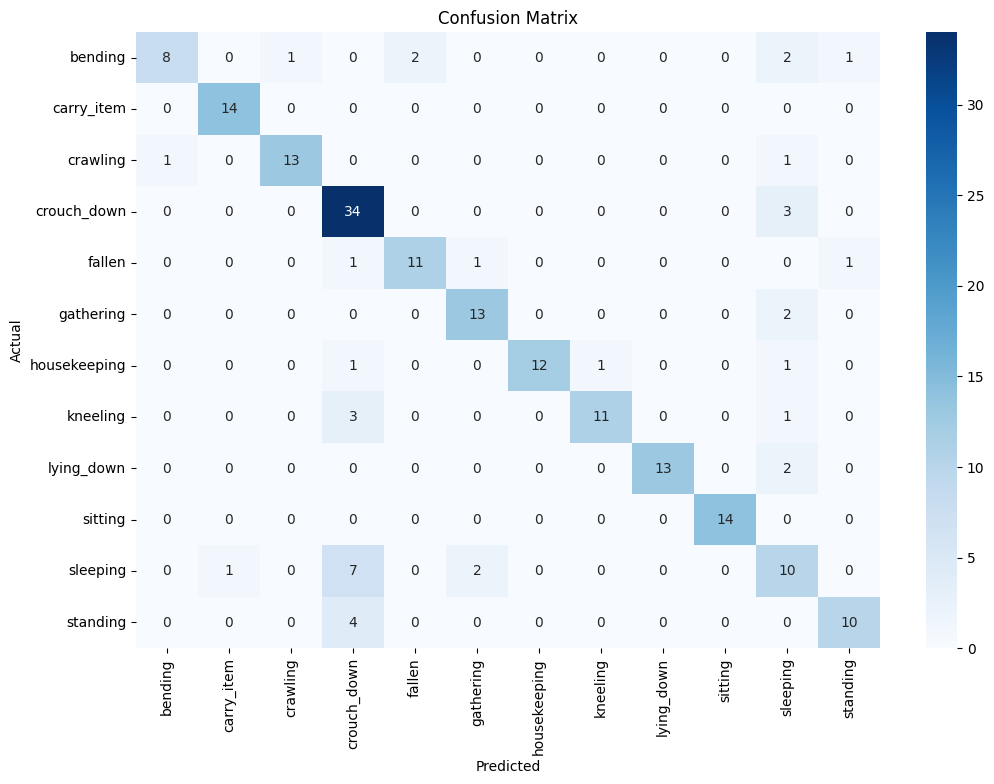

In [154]:
import seaborn as sns
cm = confusion_matrix(Y_true_labels, Y_pred_labels)
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=existing_class_names, yticklabels=existing_class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [57]:
print(cm)

[[ 0  1  0  0  0  0  0  0  0  1  0  1  0  0  1]
 [ 0  0  0  1  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  1  0  1  0  0  1  1  0  0  2  0  0]
 [ 0  1  3 18  1  1  0  1  0  2  2  2  1  4  0]
 [ 0  1  2 10  2  1  0  0  4  2  1  3  3  0  0]
 [ 0  0  0  1  0  1  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  2  0  0  0  0  0  0  0  0  2  0  1]
 [ 0  0  0  0  0  1  0  0  0  0  0  1  0  0  0]
 [ 0  0  0  1  0  0  0  0  0  1  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0  0  0  0  0  0  0]
 [ 0  0  0  2  0  1  0  0  1  0  4  1  1  0  1]
 [ 0  0  0  6  0  1  1  0  1  3  0  0  5  0  2]
 [ 0  0  0  1  0  0  0  0  0  0  0  0  0  0  1]
 [ 0  0  1  8  1  0  1  0  3  2  0  1  6  0  1]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]]


In [55]:
from sklearn.metrics import log_loss

# Predict class probabilities
Y_pred_proba = model.predict(X_test_seq)
logloss = log_loss(Y_test_seq, Y_pred_proba)
print(f"Log Loss: {logloss:.4f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step
Log Loss: 0.7537


**Log Loss (a.k.a. Cross-Entropy Loss)**

Measures how well a classifier’s predicted probability distribution matches the actual labels.

Lower log loss is better.
A perfect classifier would have a log loss of 0.

Attempt 2 model's probability estimates are decently aligned with true labels — typically, log loss under 1 for multiclass is reasonable.

In [63]:
from sklearn.metrics import cohen_kappa_score

kappa = cohen_kappa_score(Y_true_labels, Y_pred_labels)
print(f"Cohen's Kappa Score: {kappa:.4f}")

Cohen's Kappa Score: 0.7793


**Cohen’s Kappa Score**

Measures agreement between predicted and actual labels adjusted for chance agreement.

| Kappa Value | Interpretation           |
| :---------- | :----------------------- |
| < 0         | No agreement             |
| 0–0.20      | Slight                   |
| 0.21–0.40   | Fair                     |
| 0.41–0.60   | Moderate                 |
| 0.61–0.80   | Substantial/Good         |
| 0.81–1.00   | Almost perfect/Excellent |

Cohen's Kappa Score: 0.7793
**Substantial agreement** which is solid for multiclass video classification.

In [69]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize

# Get the unique class indices present in Y_test_seq
unique_true_labels = np.unique(np.argmax(Y_test_seq, axis=1))

# Get the corresponding class names
existing_class_names_in_test = [new_class_names[i] for i in unique_true_labels]

# Binarize true labels for multi-class ROC AUC using only the classes present in the test set
Y_true_bin = label_binarize(np.argmax(Y_test_seq, axis=1), classes=unique_true_labels)

# Compute ROC AUC OvR
auc = roc_auc_score(Y_true_bin, Y_pred_proba[:, unique_true_labels], average='macro', multi_class='ovr')
print(f"Multi-class ROC AUC (OvR, macro): {auc:.4f}")

Multi-class ROC AUC (OvR, macro): 0.9546


AUC 0.9546: Very high class separation performance.

ROC curves per class give an intuitive visual of how well the model ranks predictions.

In [70]:
model.save('/content/cnn_lstm_v2_final_model.h5')

blob = bucket.blob('models/cnn_lstm_v2_final_model.h5')
blob.upload_from_filename('/content/cnn_lstm_v2_final_model.h5')
print("CNN LSTM V2 Final Model uploaded to GCS.")

CNN LSTM V2 Final Model uploaded to GCS.


In [72]:
report = classification_report(Y_true_labels, Y_pred_labels, target_names=existing_class_names, output_dict=True)
df_report = pd.DataFrame(report).transpose()
df_report.to_csv('/content/cnn_lstm_v2_final model_classification_report.csv')

blob = bucket.blob('results/classification_report.csv')
blob.upload_from_filename('/content/cnn_lstm_v2_final model_classification_report.csv')

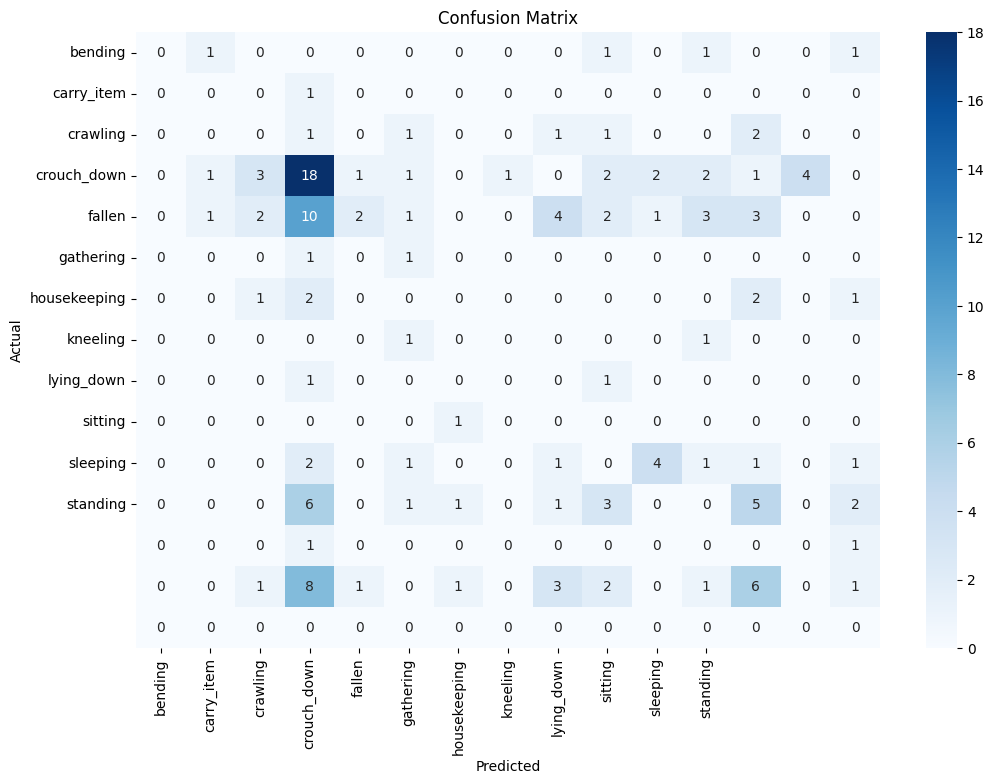

In [74]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=existing_class_names, yticklabels=existing_class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig('/content/cnn_lstm_v2_final model_confusion_matrix.png')

blob = bucket.blob('results/cnn_lstm_v2_final model_confusion_matrix.png')
blob.upload_from_filename('/content/cnn_lstm_v2_final model_confusion_matrix.png')

Learning Points in Data Preparation and Model Training (including using VGG19 vs Transfer Learning Resnet50, model performance before and after applying data augmentation, observation e.g. imbalance data, skewed data, between hot encoded and numerical data)

| Aspect                                           | Learning & Observations                                                                                                                                                                                     |
| :----------------------------------------------- | :---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Label Handling**                               | Initially had 17 classes, including *empty\_room*, *occlusion*, *unidentified* — which aren’t human actions, their presence distorted class balance and confused the model. Removing them improved clarity and class focus.                                   |
| **Class Imbalance**                              | Discovered severe imbalance — empty_room and walking had high counts, while classes like carry_item, sleeping, kneeling were under-represented. Skewed data led to poor precision/recall for minority classes initially. Direct class weighting provided limited improvement.  |
| **One-hot vs Numerical Labels**                  | Started with one-hot encoding for categorical crossentropy, then switched to numerical labels for sparse categorical crossentropy workflow, reducing computational overhead - simplified label handling, reduced memory usage, and eased class weight computation. |
| **Class Weight Application**                            | Applied class weights (computed via sklearn.utils.class_weight) to address imbalance — helped slightly but didn’t solve minority class performance alone without augmentation. *crouch\_down*.                     |
| **Data Augmentation**                            | Performed image augmentations (rotation, flip, zoom)  selectively on minority classes to artificially increase sample count. This significantly improved recall, precision, and f1-scores for previously weak classes like *fallen*, *crouch\_down*.                   |
| **Sequence Structuring**                         | Created fixed-length sequences of images (5 frames per sequence) to maintain temporal context for LSTM inputs. Ensured label alignment to final frame of each sequence. Learned importance of synchronised data structuring in sequential models.                                   |
| **Pre-Augmentation vs Post-Augmentation Counts** | Verified action class distribution before and after augmentation — observed significant improvement in minority class representation.                                                                       |


| Aspect                                  | Learning & Observations                                                                                                                                                                 |
| :-------------------------------------- | :-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **VGG19 Transfer Learning**             | Used pretrained VGG19 on ImageNet with frozen base layers. While it extracted decent features but plateaued quickly in performance (\~22% accuracy) and struggled with subtle actions and action diversity like *kneeling*, *fallen* due to limited feature granularity for human pose recognition.     |
| **ResNet50 Transfer Learning**          | Switching to ResNet50 gave a noticeable boost. Deeper network with skip connections captured finer spatial features, better generalising across complex and subtle human actions like kneeling, fallen.           |
| **Impact of Data Augmentation**    | Performance without augmentation: accuracy ~22%, f1-scores low for minority classes. After augmentation: accuracy improved to 81%, f1-scores for critical actions (fallen, crouch_down) rose from ~0.2 to 0.7–0.8 range.   |
| **Effect of Removing Non-actions**    | Removing empty_room, occlusion, unidentified resulted in a clearer, action-specific model — improved overall classification clarity, reduced label noise, and streamlined prediction focus. |
| **CNN-LSTM Sequential Architecture**    | Wrapping ResNet50 with `GlobalAveragePooling2D`, followed by `TimeDistributed` and LSTM 128 units captured both spatial (image) and temporal (sequence) information.                    |
| **Model Performance Evolution**         |  **Without Augmentation:** \~22% accuracy; <br>  **After Augmentation with ResNet50:** reached **\~81% accuracy** on test set and **\~75% validation accuracy**.                    |
| **Loss & Accuracy Trends**              | Observed steady decrease in training/validation loss and consistent accuracy rise over epochs (notably after epoch 6). EarlyStopping and Checkpoint callbacks prevented overfitting.    |
| **Transfer Learning Efficiency**        | Leveraging ImageNet pretrained weights meant faster convergence, achieving 70%+ accuracy by epoch 7 with minimal custom feature engineering.  Pretrained CNNs (VGG19/ResNet50) dramatically reduced training time and allowed the model to converge faster even with small datasets — confirming the value of transfer learning in computer vision tasks.                                     |
| **Data Imbalance Problem Insight**        | Even with class weighting, minority classes require either oversampling/augmentation or synthetic data generation (SMOTE not feasible for images) — highlighting the limitation of class weight alone for CNNs.                              |
| **Class Weight vs Augmentation Impact** | Class weighting alone wasn’t sufficient for CNN-based models; augmentation on minority classes had a tangible and positive impact on recall, precision, and F1-score for those classes. |
| **Data Format Consistency**             | Important to align `TimeDistributed` layer inputs to correct `(sequence, 224, 224, 3)` shape. Mismatches or inconsistency triggered retracing warnings.              |
| **Model Saving Format Note**            | Keras recommends switching from legacy `.h5` to native `.keras` save format for future-proofing and better serialization support.                                                |
| **Model Stability & Overfitting Control**            | EarlyStopping with patience and restoring best weights prevented overfitting on augmented data. Regular Dropout and reduced learning rates in final model tuning further improved generalisation.                                |


**Final Takeaway:**

1. ResNet50 + CNN-LSTM outperform VGG19 for human action detection from short video sequences or small video datasets.

2. Data augmentation on minority classes; recall and precision improved notably for critical actions like fallen and crouch_down.

3. Removing irrelevant labels (non-action) from target classes is essential as it strengthens model focus and improves classification reliability; for effective human activity classification.

4. Transfer Learning with frozen ResNet50 backbone + Sequence Modelling (CNN-LSTM) is a viable combo for behaviour anomaly detection using video frames. It accelerates convergence and leverages rich pretrained spatial features.

5. Data sequence structuring is essential for accurate temporal modeling in action recognition tasks.

6. Sparse categorical crossentropy with integer labels simplifies sequential classification workflows.

7. Class imbalance in image sequences requires augmentation more than class weight adjustment alone.

8. EarlyStopping + ModelCheckpoint callbacks maintain training efficiency, prevent overfitting, and preserve optimal weights.

9. Monitor retracing warnings by ensuring consistent tensor shapes and defining @tf.function outside loops where necessary.



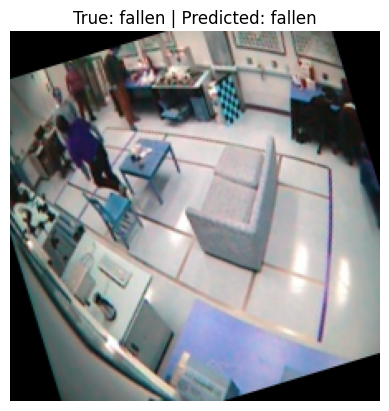

In [108]:
import random
idx = random.randint(0, len(X_test_seq) - 1)

# Show the last frame in that sequence (usually represents the label)
image = X_test_seq[idx][-1]  # shape (224, 224, 3)

true_label = new_class_names[Y_true_labels[idx]]
pred_label = new_class_names[Y_pred_labels[idx]]

plt.imshow(image.astype('uint8'))
plt.title(f"True: {true_label} | Predicted: {pred_label}")
plt.axis('off')
plt.show()

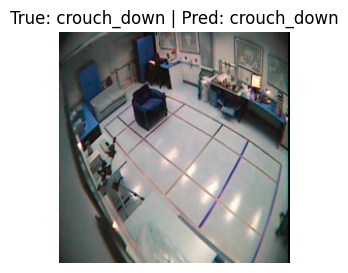

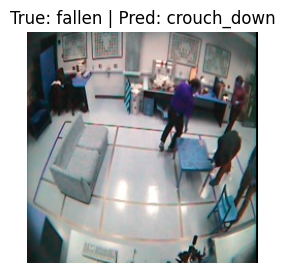

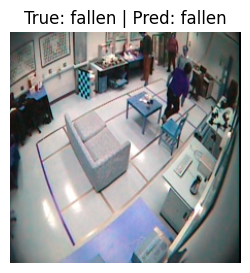

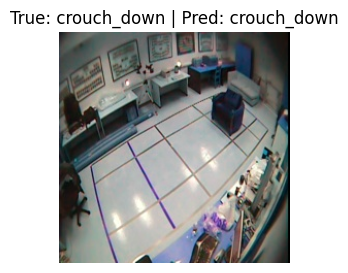

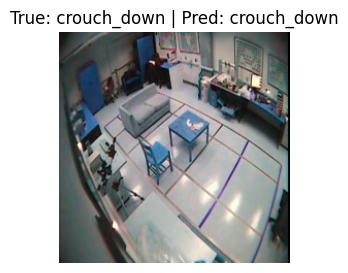

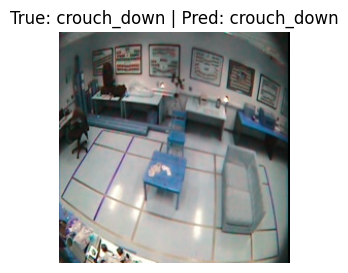

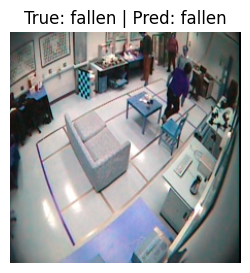

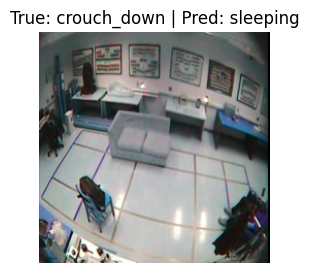

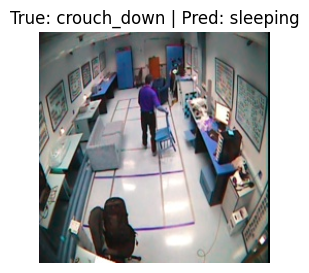

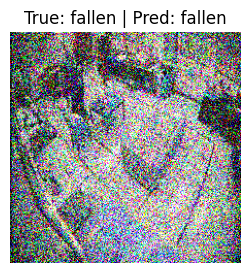

In [110]:
important_classes = ['fallen', 'crouch_down']
important_indices = [i for i in range(len(Y_true_labels))
                     if new_class_names[Y_true_labels[i]] in important_classes]

for idx in important_indices[:10]:
    image = X_test_seq[idx][-1]
    true_label = new_class_names[Y_true_labels[idx]]
    pred_label = new_class_names[Y_pred_labels[idx]]

    plt.figure(figsize=(3, 3))
    plt.imshow(image.astype('uint8'))
    plt.title(f"True: {true_label} | Pred: {pred_label}")
    plt.axis('off')
    plt.show()

“Accuracy high, images annotated wrong”

1. Label noise / annotation error

2. Class imbalance (model memorising majority classes)

3. Transition ambiguity (e.g. standing vs crouch_down mid-frame)

4. Misalignment of video frames vs labels during sequence slicing

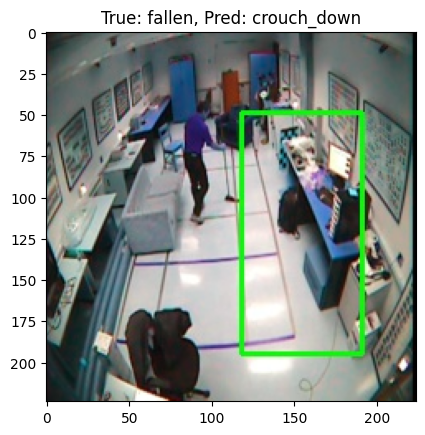

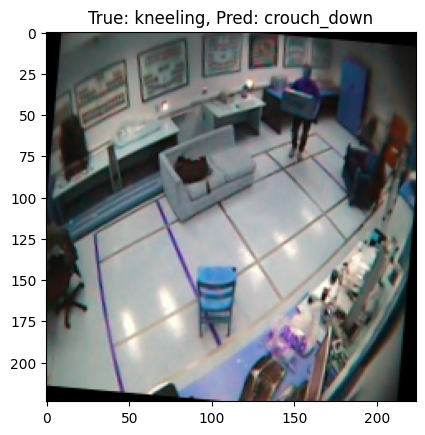

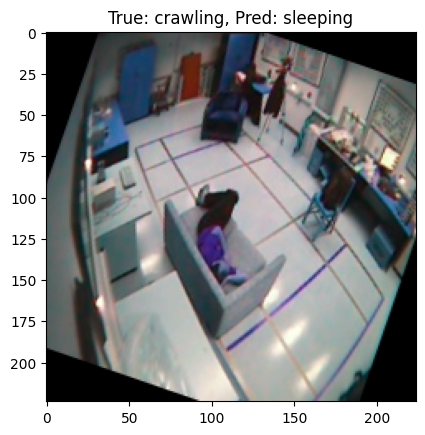

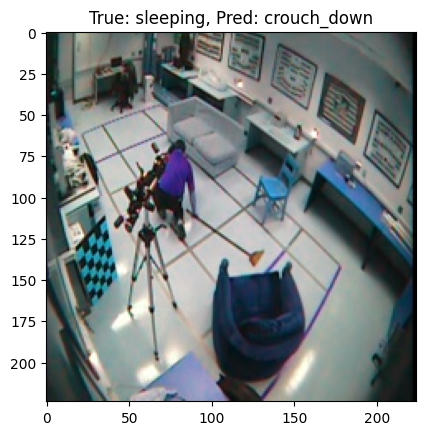

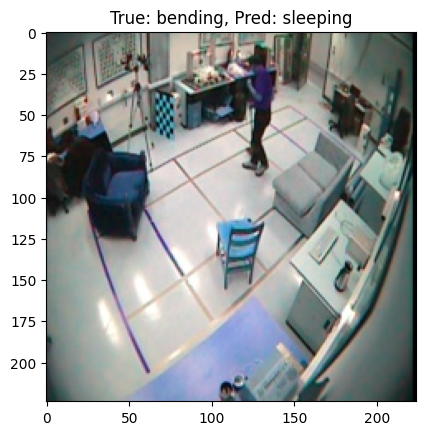

In [112]:
wrong_idx = np.where(Y_true_labels != Y_pred_labels)[0]
for idx in wrong_idx[:5]:
    plt.imshow(X_test_seq[idx, 0])  # show first frame of sequence
    plt.title(f"True: {existing_class_names[Y_true_labels[idx]]}, Pred: {existing_class_names[Y_pred_labels[idx]]}")
    plt.show()

# Upload to GCS

In [113]:
!cp "/content/drive/MyDrive/Colab Notebooks/P2-06_CNN2-vid.ipynb" "/content/P2-06_CNN2-vid.ipynb"

client = storage.Client(project='p2-anomaly')
bucket = client.bucket('p2-anomaly')
notebook_blob = bucket.blob('notebooks/P2-06_CNN2-vid.ipynb')
notebook_blob.upload_from_filename('/content/P2-06_CNN2-vid.ipynb')
print("Notebook pushed to GCS.")

Notebook pushed to GCS.


In [114]:
!jupyter nbconvert --to script "/content/P2-06_CNN2-vid.ipynb" --output "/content/P2-06_CNN2-vid"
!mv /content/P2-06_CNN2-vid.txt /content/P2-06_CNN2-vid.py
local_script_path = '/content/P2-06_CNN2-vid.py'
gcs_script_path = 'scripts/P2-06_CNN2-vid.py'

# Upload to GCS
blob = bucket.blob(gcs_script_path)
blob.upload_from_filename(local_script_path)

print("Script uploaded to GCS.")

[NbConvertApp] Converting notebook /content/P2-06_CNN2-vid.ipynb to script
[NbConvertApp] Writing 19993 bytes to /content/P2-06_CNN2-vid.txt
Script uploaded to GCS.
